In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import os
import gseapy
from sklearn import preprocessing


from ete3 import Tree

import pickle as pic

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import scipy.stats as scs

from tqdm import tqdm

import utilities.de_utils as de_utils
from rpy2.robjects import pandas2ri
import anndata2ri

import rpy2
import logging 


from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
from scvi.dataset import AnnDatasetFromAnnData

import torch

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')



/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
import scvi
scvi.__path__

['/home/eecs/mattjones/.local/lib/python3.6/site-packages/scvi']

## Read in and process data

In [3]:
# path = '/data/yosef2/users/mattjones/projects/metastasis/10k/RNA/hg19/'
path = '/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/GRCh38/'
adata = sc.read(path + "matrix.mtx", cache=True).T
genes = pd.read_csv(path + "genes.tsv", header=None, sep='\t')
adata.var_names = genes[1]
adata.var['gene_ids'] = genes[0]  # add the gene ids as annotation of the variables/genes
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

all_genes = adata.var_names

meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col=0)
latent = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/latent.csv", sep='\t', index_col = 0)
#meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/10k/10k_meta.txt", sep='\t', index_col = 0)
#latent = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/10k/RNA/latent.csv", sep='\t', index_col = 0)
latent.index = adata.obs_names

gene_list = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values
#gene_list = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/10k/RNA/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values
adata.shape, latent.shape, meta.shape 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


((43423, 33694), (43423, 10), (40969, 8))

In [4]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['nUMI'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1

adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

adata.obs = adata.obs.merge(meta, left_index = True, right_index=True, how="left")

meta_filter = np.logical_not(adata.obs["DynamicMetScore"].isna())
adata = adata[meta_filter,:]

In [20]:
# get highly or lowly metastati clones

top_perc = np.percentile(adata.obs['DynamicMetScore'], 90)
bot_perc = np.percentile(adata.obs['DynamicMetScore'], 10)

met_filter = adata.obs.apply(lambda x: x.DynamicMetScore >= top_perc or x.DynamicMetScore <= bot_perc, axis=1)
adata_met = adata[met_filter,:]

In [22]:
thresh = 0.01*adata_met.shape[0]

sc.pp.filter_genes(adata_met, min_cells=thresh)

# Use scVI for Differential Expression

In [28]:
def predict_de_genes(posterior_probas: np.ndarray, desired_fdr: float):
    """
    :param posterior_probas: Shape (n_samples, n_genes)
    :param desired_fdr:
    :return:
    """
    assert posterior_probas.ndim == 1
    sorted_genes = np.argsort(-posterior_probas)
    sorted_pgs = posterior_probas[sorted_genes]
    cumulative_fdr = (1.0 - sorted_pgs).cumsum() / (1.0 + np.arange(len(sorted_pgs)))
    d = (cumulative_fdr <= desired_fdr).sum()
    pred_de_genes = sorted_genes[:d]
    is_pred_de = np.zeros_like(cumulative_fdr).astype(bool)
    is_pred_de[pred_de_genes] = True
    return is_pred_de

def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 5,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
):
    """Train and return a scVI model and sample a latent space
    
    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    scviDataset = AnnDatasetFromAnnData(adata)

    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_latent=n_latent,
    )
    trainer = UnsupervisedTrainer(vae, scviDataset, train_size=1.0, use_cuda=use_cuda)
    trainer.train(n_epochs=n_epochs, lr=lr)
    ####

    # Extract latent space
    posterior = trainer.create_posterior(
        trainer.model, scviDataset, indices=np.arange(len(scviDataset))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent


In [24]:
n_epochs = 30
lr = 1e-3

# use_cuda to use GPU
use_cuda = True
n_latent = 10

scviDataset=AnnDatasetFromAnnData(adata_met)
vae = VAE(
    scviDataset.nb_genes,
    n_batch=scviDataset.n_batches * False,
    n_latent=n_latent,
)
trainer = UnsupervisedTrainer(vae, scviDataset, train_size=0.9, use_cuda=use_cuda, frequency=1)
trainer.train(n_epochs=n_epochs, lr=lr)

scvi_posterior = trainer.create_posterior(trainer.model, scviDataset, indices=np.arange(len(scviDataset))).sequential()
scvi_latent,_,_ = scvi_posterior.get_latent()

adata_met.obsm["X_scvi"] = scvi_latent


[2020-02-18 17:07:30,652] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-02-18 17:07:30,937] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-02-18 17:07:30,940] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-02-18 17:07:32,680] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-02-18 17:07:32,772] INFO - scvi.dataset.dataset | Downsampled from 7003 to 7003 cells
[2020-02-18 17:07:33,158] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.



[2020-02-18 17:08:05,962] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


In [39]:
scviDataset.labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint16)

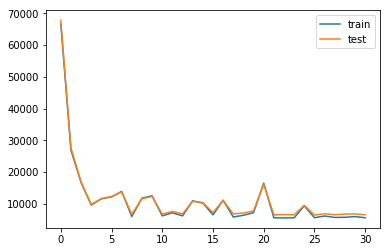

In [25]:
elbo_train = trainer.history["elbo_train_set"]
elbo_test = trainer.history["elbo_test_set"]
x = np.linspace(0, 30, (len(elbo_train)))
plt.plot(x, elbo_train, label="train")
plt.plot(x, elbo_test, label="test")
# plt.ylim(min(elbo_train)-50, 1000)
plt.legend()

In [44]:
# top_perc = np.percentile(adata.obs['DynamicMetScore'], 90)
# bot_perc = np.percentile(adata.obs['DynamicMetScore'], 10)

cell_idx1 = adata_met.obs.apply(lambda x: x.DynamicMetScore >= top_perc, axis=1).values
cell_idx2 = adata_met.obs.apply(lambda x: x.DynamicMetScore <= bot_perc, axis=1).values

print('running de')
de = scvi_posterior.differential_expression_score(
    idx1=cell_idx1,
    idx2=cell_idx2,
    n_samples=10000,
    use_permutation=False,
    #delta=1,
    mode="change",
)

running de


In [57]:
deii = predict_de_genes(de['proba_de'], desired_fdr = 0.1)
np.mean(deii)
de.loc[deii,:]

de_genes = de.loc[deii,:].index
# de.loc['IFI6']

In [58]:
de['color'] = de.apply(lambda x: 'red' if x.name in de_genes else 'black', axis=1)
de['log_proba_not'] = -np.log(de['proba_not_de'])

In [59]:
-np.log(0.5)

0.6931471805599453

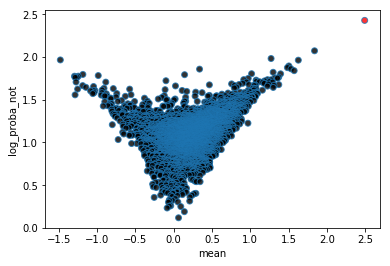

In [60]:
sns.regplot(data = de, x='mean', y='log_proba_not', scatter_kws={'facecolors': de['color']}, fit_reg=False)

In [58]:
de.to_csv("metastasis_5k_deres.txt", sep='\t')

In [101]:
# scale_factor = np.median(np.array(adata.X.sum(axis=1)))
# sc.pp.normalize_per_cell(adata, counts_per_cell_after = scale_factor)

# # sc.pp.log1p(adata)

# adata.raw = adata

# filter_result = list(map(lambda x: x in gene_list, adata.var_names))
# # sc.pl.filter_genes_dispersion(filter_result)
# adata = adata[:, filter_result]

/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Perform DE analyses 

### try using MAST

In [37]:
adata_test = adata.copy()
adata_test.X = adata.raw.X
adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1)

## Divide cells based on metastatic ability

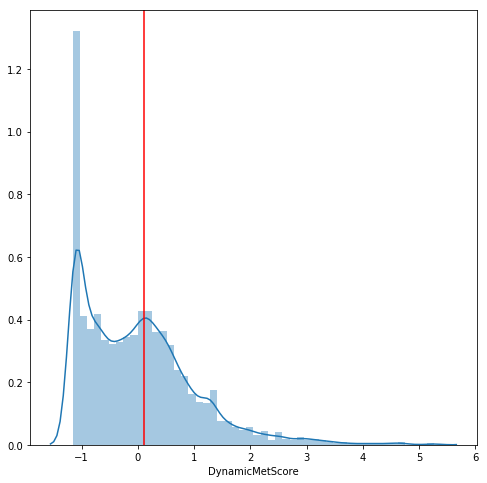

ranking genes


... storing 'sampleID' as categorical
... storing 'Sample2' as categorical
... storing 'Groupby' as categorical
... storing 'gene_ids' as categorical
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:223: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


In [91]:
x = adata.obs['DynamicMetScore']
x=(x-x.mean())/x.std()


sns.distplot(x)
plt.axvline(x=0.1, color='red')
plt.show()

met_threshold = 0.1
adata_met = adata.copy()
adata_met.obs['Groupby'] = adata_met.obs.apply(lambda x: 'High' if x.DynamicMetScore > met_threshold else 'BG', axis=1)
sc.tl.rank_genes_groups(adata_met, 'Groupby', groups=['High'], reference='BG', n_genes = 300, only_positive=False)

In [86]:
result = adata_met.uns["rank_genes_groups"]
groups = result['names'].dtype.names

met_de = de_utils.create_DE_df(adata_met, "Groupby", "High", "BG", result)
# met_de.to_csv("data/10k/high_met_de.txt", sep='\t')
# met_de = met_de[met_de['qval'] < 0.05]

# unique_genes = de_utils.consolidate_genes([met_de], lgfc_thresh=0.7)

# met_de_bulk = de_utils.bulk_by_group(adata_met.obs['Groupby'], adata_met, unique_genes)



(35006, 33694) 35006 [False  True  True False False  True  True  True  True False]


In [87]:
met_de.shape

(300, 3)

/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


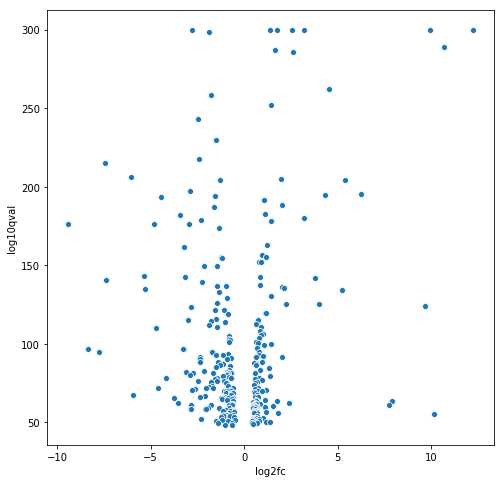

,qval,gene,log2fc,log10qval
5,0.000000e+00,MT-CO2,12.243514,300.000000
8,2.168295e-289,MT-CO1,10.698840,288.663882
261,7.728499e-56,MALAT1,10.132854,55.111905
6,0.000000e+00,S100A4,9.942320,300.000000
70,1.018519e-124,MUC5AC,9.684555,123.992031
208,3.722400e-64,TMSB4X,7.917603,63.429177
223,8.007345e-62,S100A6,7.726286,61.096511
24,3.761730e-196,TFF1,6.255220,195.424612
21,2.304077e-205,MT-CO3,5.366224,204.637503
63,7.255469e-135,AGR2,5.235497,134.139335


In [88]:
met_de['log10qval'] = -np.log10(met_de['qval'])
met_de.loc[met_de['log10qval'] == np.inf, 'log10qval'] = 300

sns.scatterplot(met_de['log2fc'], met_de['log10qval'])
plt.show()

met_de.sort_values(by='log2fc', ascending=False).head(20)

### First compare highly metastatic clones to lowly

In [54]:
adata_met = de_utils.filter_data_continuous(adata, 'StaticMetScore', 0.3)

perc = np.percentile(adata_met.obs['DynamicMetScore'], 50)
perc = 0.16
adata_met.obs['Groupby'] = adata_met.obs.apply(lambda x: 'High' if x.DynamicMetScore > perc else 'BG', axis=1)
# adata_met = de_utils.split_data_continuous(adata_met, 'DynamicMetScore', perc)
sc.tl.rank_genes_groups(adata_met, "Groupby", groups=["High"], reference="BG", method="wilcoxon", n_genes = 7000, only_positive = False)

Trying to set attribute `.obs` of view, making a copy.
... storing 'sampleID' as categorical
... storing 'Groupby' as categorical
... storing 'gene_ids' as categorical


In [57]:
result = adata_met.uns["rank_genes_groups"]
groups = result['names'].dtype.names

met_de = de_utils.create_DE_df(adata_met, "Groupby", "High", "BG", result)
met_de.to_csv("data/10k/high_met_de.txt", sep='\t')
met_de = met_de[met_de['qval'] < 0.05]

unique_genes = de_utils.consolidate_genes([met_de])

met_de_bulk = de_utils.bulk_by_group(adata_met.obs['Groupby'], adata_met, unique_genes)

(1611, 4438) 1611 [False  True False  True False False  True  True  True  True]


100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


In [56]:
met_de[met_de['gene'] == 'IFI6']

,qval,gene,log2fc
11,3.361340e-12,IFI6,1.145089


### Compare top 10% to bottom 10%

In [157]:
top_perc = np.percentile(adata.obs['DynamicMetScore'], 90)
bot_perc = np.percentile(adata.obs['DynamicMetScore'], 10)

print(bot_perc, top_perc)
def annotate_met_scores(x, topthresh, botthresh):
    
    if x >= topthresh:
        return 'Top'
    if x <= botthresh:
        return 'Bot'
    return 'BG'


adata.obs['Groupby'] = adata.obs.apply(lambda x: annotate_met_scores(x['DynamicMetScore'], top_perc, bot_perc), axis=1)

sc.tl.rank_genes_groups(adata, "Groupby", groups=["Top"], reference="Bot", method="wilcoxon", only_positive = False)
result_top = adata.uns["rank_genes_groups"]
sc.tl.rank_genes_groups(adata, "Groupby", groups=["Bot"], reference="Top", method="wilcoxon", only_positive = False)
result_bot = adata.uns["rank_genes_groups"]

0.004149377773723767 0.2106666214902197
ranking genes


... storing 'sampleID' as categorical
... storing 'Sample2' as categorical
... storing 'Groupby' as categorical
... storing 'gene_ids' as categorical
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:325: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:332: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:16)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:16)


In [114]:
de_top = de_utils.create_DE_df(adata, 'Groupby', 'Top', 'Bot', result_top)
de_bot = de_utils.create_DE_df(adata, 'Groupby', 'Bot', 'Top', result_bot)

# flip de_bot to make it relative to top
de_bot['log2fc'] = -1*de_bot['log2fc']

met_de = pd.concat([de_top, de_bot])

# result = adata.uns["rank_genes_groups"]
# groups = result['names'].dtype.names

# met_de = de_utils.create_DE_df(adata, "Selection", "Top", "Bot", result)
# # met_de.to_csv("data/5k/met_top_vs_bot.txt", sep='\t')
met_de = met_de[met_de['qval'] < 0.05]

unique_genes = de_utils.consolidate_genes([met_de])

met_de_bulk = de_utils.bulk_by_group(adata.obs['Groupby'], adata, unique_genes)

(35006, 33694) 35006 [False  True  True False False  True False False False False]
(35006, 33694) 35006 [ True False False  True False False False False False False]


100%|██████████| 3/3 [00:03<00:00,  1.52s/it]


/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


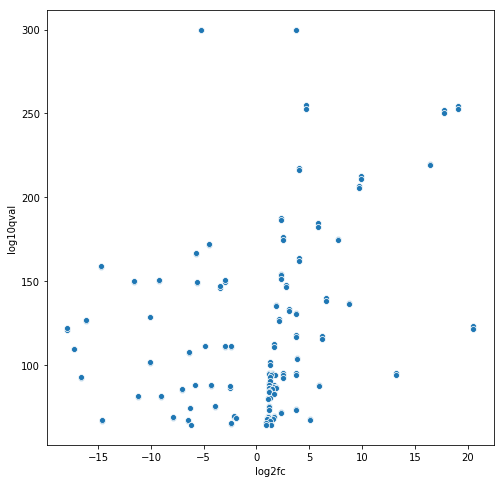

,qval,gene,log2fc,log10qval
27,1.467036e-136,FTL,inf,135.833559
35,2.634880e-122,TMSB4X,20.538889,121.579239
34,1.171433e-123,TMSB4X,20.538889,122.931283
3,1.817439e-255,MT-CO2,19.127314,254.740540
3,1.379650e-253,MT-CO2,19.127314,252.860231
4,4.626833e-253,MT-CO1,17.785406,252.334716
4,3.514692e-251,MT-CO1,17.785406,250.454113
5,1.141090e-220,S100A4,16.430943,219.942680
5,7.743753e-220,S100A4,16.430943,219.111048
50,9.866240e-95,MUC5AC,13.178590,94.005848


In [112]:
met_de['log10qval'] = -np.log10(met_de['qval'])
met_de.loc[met_de['log10qval'] == np.inf, 'log10qval'] = 300

sns.scatterplot(met_de['log2fc'], met_de['log10qval'])
plt.show()

met_de.sort_values(by='log2fc', ascending=False).head(20)

### LL only samples

In [142]:
adata_ll = de_utils.filter_data_discrete(adata, 'sampleID', ["LL"])
ll_groups = [29, 46, 78, 94]
adata_ll = de_utils.split_data_discrete(adata_ll, 'LineageGroup', ll_groups)

sc.tl.rank_genes_groups(adata_ll, "Groupby", groups=ll_groups, reference="BG", method="wilcoxon", n_genes = len(adata.var_names), only_positive = False)

Trying to set attribute `.obs` of view, making a copy.


ranking genes


... storing 'sampleID' as categorical
... storing 'Sample2' as categorical
... storing 'Groupby' as categorical
... storing 'condition' as categorical
... storing 'gene_ids' as categorical
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:325: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:332: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


--> Few observations in a group for normal approximation (<=25). Lower test accuracy.
--> Few observations in a group for normal approximation (<=25). Lower test accuracy.
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


In [155]:
result = adata_ll.uns["rank_genes_groups"]
groups = result['names'].dtype.names

lg29_ll = de_utils.create_DE_df(adata_ll, "Groupby", "29", "BG", result)
lg36_ll = de_utils.create_DE_df(adata_ll, "Groupby", "46", "BG", result)
lg78_ll = de_utils.create_DE_df(adata_ll, "Groupby", "78", "BG", result)
lg94_ll = de_utils.create_DE_df(adata_ll, "Groupby", "94", "BG", result)

# lg29_ll.to_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/lg29_ll.txt", sep='\t')
# lg36_ll.to_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/lg36_ll.txt", sep='\t')
# lg78_ll.to_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/lg78_ll.txt", sep='\t')
# lg94_ll.to_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/lg94_ll.txt", sep='\t')

lg29_ll = lg29_ll[(lg29_ll['qval'] < 0.05) & (np.abs(lg29_ll['log2fc']) > np.log2(2))]
lg36_ll = lg36_ll[(lg36_ll['qval'] < 0.05) & (np.abs(lg36_ll['log2fc']) > np.log2(2))]
lg78_ll = lg78_ll[(lg78_ll['qval'] < 0.05) & (np.abs(lg78_ll['log2fc']) > np.log2(2))]
lg94_ll = lg94_ll[(lg94_ll['qval'] < 0.05) & (np.abs(lg94_ll['log2fc']) > np.log2(2))]


unique_genes = de_utils.consolidate_genes([lg29_ll, lg36_ll, lg78_ll, lg94_ll])

ll_de_bulk = de_utils.bulk_by_group(adata_ll.obs['Groupby'], adata_ll, unique_genes)

(1867, 33694) 1867 [False False False  True False False False False False False]
(1867, 33694) 1867 [ True False False False False False False False False False]
(1867, 33694) 1867 [False False False False False False False False False False]
(1867, 33694) 1867 [False False False False False False False False False False]


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


In [152]:
lg29_ll.head(5)

,qval,gene,log2fc
0,1.086935e-47,PRKCDBP,-5.184936
1,3.929987e-32,RPS15A,14.167834
2,1.077001e-31,RPL26,19.560026
3,4.251783e-30,MUC5AC,-36.815678
4,1.034099e-29,RPS5,18.935263


<Figure size 1008x720 with 0 Axes>

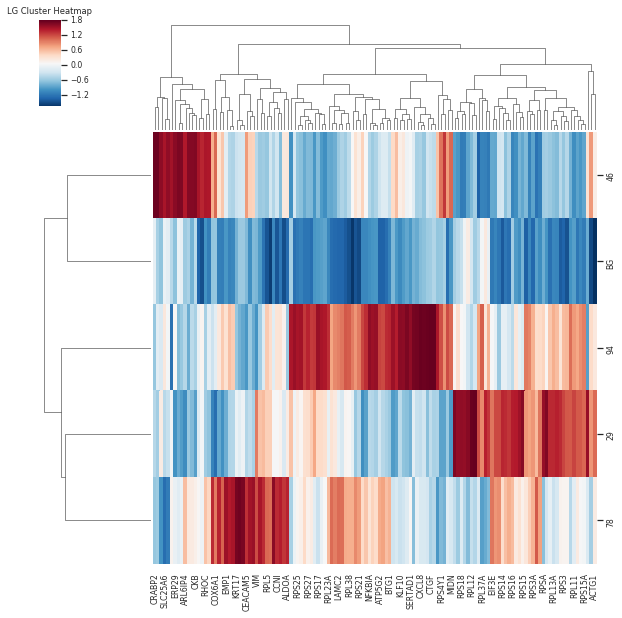

In [156]:
sns.set(font_scale=0.7)
plt.figure(figsize=(14, 10))
hm = sns.clustermap(ll_de_bulk, cmap="RdBu_r", z_score=1, fmt='d')
plt.title("LG Cluster Heatmap")
# plt.savefig("figs/5k_ll_clusterheatmap.pdf")
plt.show()